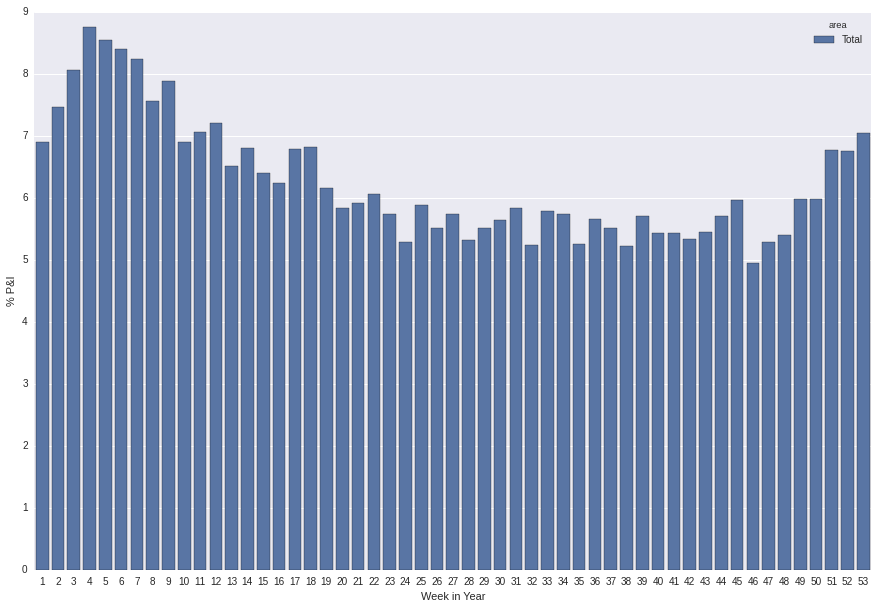

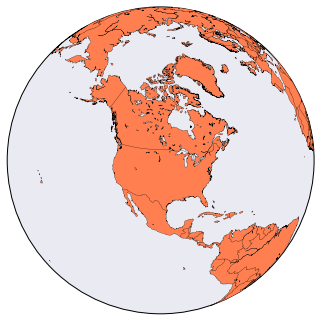

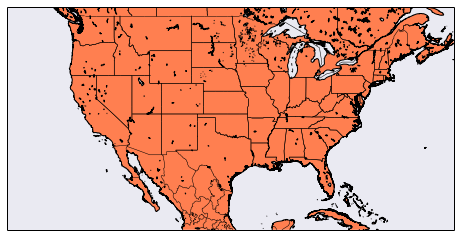

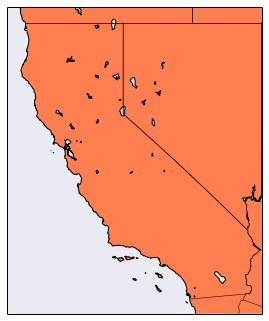

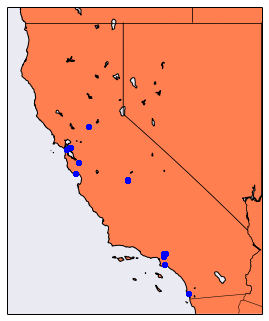

In [1]:
%run '04_formatted.ipynb'

We've upgraded a little since the last post. In particular, I'm using the newest version of IPython/Jupyter Notebook which allows us to run old notebooks inside new ones with the %run magic function. 

In this way, we're able to keep all our functions and objects but we don't need to clutter up the beginning of every post with a huge chunk of code. We're that much better equipped for our exploratory computing.

Just to make sure we can use the objects we defined earlier, let's test something that we know should be there.

In [2]:
cali[:5]

,area,deaths,lat,long,city,state
115,"Berkeley, CA",15,37.869884,-122.270539,Berkeley,CA
116,"Fresno, CA",137,36.740680,-119.785728,Fresno,CA
117,"Glendale, CA",29,34.146333,-118.248640,Glendale,CA
119,"Long Beach, CA",55,33.766724,-118.192397,Long Beach,CA
120,"Los Angeles, CA",224,34.053491,-118.245317,Los Angeles,CA


Good, everything seems to be in order.

Let's take things a little slow, and do one step at a time. If we want to display any sort of geographic information, we should probably start with getting labels on our test map.

Let's remind ourselves of what we've been doing and make a plan for the next step:

---

We're working on the data that can be found at https://catalog.data.gov/dataset/table-iii-deaths-in-122-u-s-cities, which is a collection of data on the deaths recorded in 122 US cities. We've done some basic manipulation and some fun visualizations, some of which we saw when we loaded the previous notebook. 

We'll do a little bit more on that today.

First, we'll want to make a list of the unique areas that show up in California, as that is the subsection of the data that we're looking at for the moment. Then we'll go through and pull the latitude and the longitude from the first instance of each of those areas. We can then use this data to add labels to our map. With any luck, this will be a quick and useful endeavor.

First thing's first.

In [3]:
unique_cali = pd.unique(cali['area'].ravel())
unique_cali

array(['Berkeley, CA', 'Fresno, CA', 'Glendale, CA', 'Long Beach, CA',
       'Los Angeles, CA', 'Pasadena, CA', 'Sacramento, CA',
       'San Diego, CA', 'San Francisco, CA', 'San Jose, CA',
       'Santa Cruz, CA'], dtype=object)

Nice. Cracking on. Let's turn this into a list, to make it easier for us to use.

In [4]:
to_take = []
for area in unique_cali:
    to_take.append(area)
to_take

['Berkeley, CA',
 'Fresno, CA',
 'Glendale, CA',
 'Long Beach, CA',
 'Los Angeles, CA',
 'Pasadena, CA',
 'Sacramento, CA',
 'San Diego, CA',
 'San Francisco, CA',
 'San Jose, CA',
 'Santa Cruz, CA']

In [5]:
rows_for_cali = []
for row in cali.index:
    if cali['area'].ix[row] in to_take:
        rows_for_cali.append(row)
        for x in range(len(to_take)):
            if to_take[x] == cali.ix[row]['area']:
                to_take.pop(x)
                break
rows_for_cali

[115, 116, 117, 119, 120, 121, 123, 124, 125, 126, 127]

In [6]:
cali_min = cali.drop([row for row in cali.index
                     if row not in rows_for_cali], axis = 0)
cali_min

,area,deaths,lat,long,city,state
115,"Berkeley, CA",15,37.869884,-122.270539,Berkeley,CA
116,"Fresno, CA",137,36.740680,-119.785728,Fresno,CA
117,"Glendale, CA",29,34.146333,-118.248640,Glendale,CA
119,"Long Beach, CA",55,33.766724,-118.192397,Long Beach,CA
120,"Los Angeles, CA",224,34.053491,-118.245317,Los Angeles,CA
121,"Pasadena, CA",27,34.147454,-118.144266,Pasadena,CA
123,"Sacramento, CA",207,38.579333,-121.490896,Sacramento,CA
124,"San Diego, CA",166,32.715691,-117.161717,San Diego,CA
125,"San Francisco, CA",108,37.777122,-122.419637,San Francisco,CA
126,"San Jose, CA",196,37.338582,-121.885570,San Jose,CA


Nice, now we've got a much simpler set of the data we want to represent.

In [8]:
c_lat = [cali_min['lat'].loc[row]
            for row in cali_min.index]
c_long = [cali_min['long'].loc[row]
            for row in cali_min.index]

Let's just reiterate what the function looks like, then we'll recreate our test map but with the DataFrame that we've just made.

In [9]:
def test_map(lons, lats, msize = 12, 
              x1 = -125., y1 = 25., 
              x2 = -65, y2 = 50.):
    ''' lons and lats are series or lists or longitude 
        and latitude respectively to plot on map
        x1,y1 for lower left corner long and lat
        x2,y2 for upper right corner long and lat
        automatically set to map US, 
        because...you know...jingoism'''
    
    map = Basemap(projection='merc', 
        lat_0 = (y1 + y2)/2, lon_0 = (x1 + x2)/2,
        resolution = 'h', area_thresh = 0.1,
        llcrnrlon=x1, llcrnrlat=y1,
        urcrnrlon=x2, urcrnrlat=y2)
 
    map.drawcoastlines()
    map.drawcountries()
    map.fillcontinents(color = 'coral')
    map.drawmapboundary()
    
    for x, y in zip(lons, lats):
        x, y  = map(lons, lats)
        map.plot(x, y, 'bo', markersize = msize)

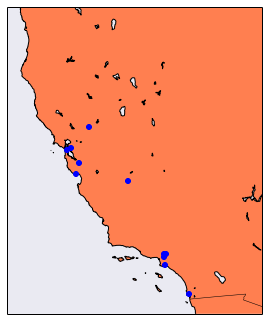

In [10]:
test_map(c_long, c_lat, 5, -125., 32., -114., 42.5)

Good stuff. Now let's collect the labels from the 'city' column.

In [12]:
cali_labels = [cali_min['city'].ix[row]
                  for row in cali_min.index]
cali_labels

['Berkeley',
 'Fresno',
 'Glendale',
 'Long Beach',
 'Los Angeles',
 'Pasadena',
 'Sacramento',
 'San Diego',
 'San Francisco',
 'San Jose',
 'Santa Cruz']

Goodie gum drops. Now then, we should redo the the test map to include some labeling.

In [13]:
def test_map_labels(lons, lats, msize = 12, 
                      x1 = -125., y1 = 25., 
                      x2 = -65., y2 = 50.,
                      labels = [], 
                      labels_lons = [], 
                      labels_lats = []):
    ''' lons and lats are series or lists or longitude 
        and latitude respectively to plot on map
        x1,y1 for lower left corner long and lat
        x2,y2 for upper right corner long and lat
        '''
    
    map = Basemap(projection='merc', 
        lat_0 = (y1 + y2)/2, lon_0 = (x1 + x2)/2,
        resolution = 'h', area_thresh = 0.1,
        llcrnrlon=x1, llcrnrlat=y1,
        urcrnrlon=x2, urcrnrlat=y2)
 
    map.drawcoastlines()
    map.drawcountries()
    map.fillcontinents(color = 'coral')
    map.drawmapboundary()
    
    
    x, y  = map(lons, lats)
    map.plot(x, y, 'bo', markersize = msize)
    
    for label, xpos, ypos in zip(labels, x, y):
        plt.text(xpos, ypos, label)

Now, I included extra perameters for the label locations. This way we can specify where the labels go if they need to be different from the marker locations. 

Anyway, let's give this a go.

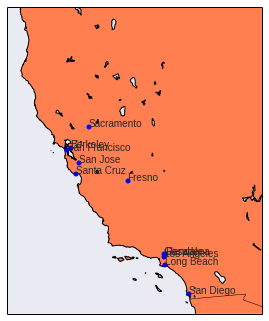

In [16]:
test_map_labels(c_long, c_lat, 5, 
                -125., 32., -114., 42.5, 
                cali_labels, c_long, c_lat)

Well.. That mostly worked. We're going to have to make use of the separate locations for labels. I also seemed to have dropped the state borders somewhere along the way. We'll fix these problems in the next post. We've made progress, and more is soon to come.